In [98]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from efficientFrontier import make_ForecastDF
import scipy.optimize as sco

In [99]:
df = make_ForecastDF('jsons/universalForecast.json', 50)
returns = df.pct_change() 

In [101]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(1)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate, table):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(table.columns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [131]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, table):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate, table)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    #sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['weight'])
    max_sharpe_allocation.weight = [round(i*100,2)for i in max_sharpe_allocation.weight]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol = min_variance(mean_returns, cov_matrix)
    #sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['weight'])
    min_vol_allocation.weight = [round(i*100,2)for i in min_vol_allocation.weight]
    min_vol_allocation = min_vol_allocation.T
    
    fig = plt.figure()
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='viridis', marker='o', s=8, alpha=1)
    plt.colorbar()
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('volatility')
    plt.ylabel('returns')
        
    return fig, min_vol_allocation, max_sharpe_allocation

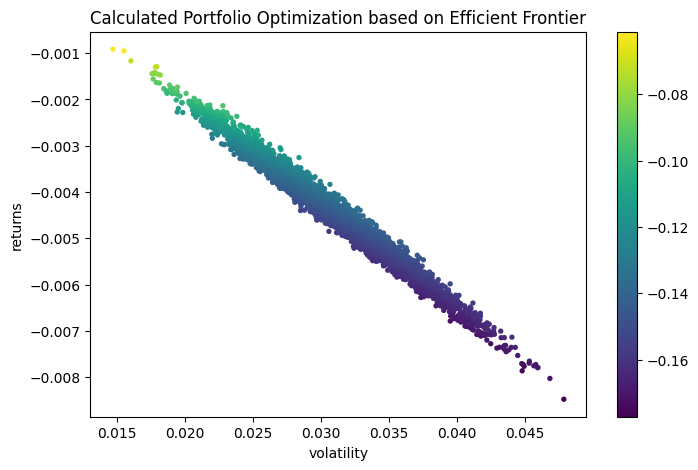

In [132]:
returns = df.pct_change() 
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000
risk_free_rate = 0
fig = display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, df)